In [111]:
%load_ext autoreload
%autoreload 2

import random
import keras
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.models import Input, Model
from keras.layers import LSTM, Dense, Merge
from keras.optimizers import Adam

from laughter_classification.sspnet_data_sampler import SSPNetDataSampler
from laughter_classification.visualization import plot_ROC_curve
from laughter_prediction.feature_extractors import LibrosaExtractor
from laughter_prediction.predictors import RnnPredictor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
FRAME_LENGTH_SECONDS = 0.5
CLASSES = 2

In [89]:
sampler = SSPNetDataSampler('data/vocalizationcorpus/')
sampler.create_sampled_df(FRAME_LENGTH_SECONDS, save_path='data/samples.csv')

saving df:  data/samples.csv


,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V140,V141,V142,V143,V144,V145,V146,V147,IS_LAUGHTER,SNAME
0,710.280301,32.296082,15.100976,29.155917,-4.035246,22.141798,-15.877404,13.819571,-2.928351,-9.046097,...,4.666456e+05,4.967411e+05,2.945196e+05,2.424304e+05,2.456876e+05,2.496487e+05,1.374698e+05,1.086777e+04,0,S0001
1,719.515601,33.206601,7.611699,28.326748,-1.907073,22.391063,-16.011634,12.116650,-3.536867,-6.149718,...,4.793456e+05,4.687479e+05,2.953435e+05,2.545017e+05,2.621245e+05,2.558948e+05,1.410388e+05,1.068502e+04,0,S0001
2,731.599403,35.540371,-5.365412,25.578094,5.448048,21.905820,-20.556192,13.096433,-0.895015,-6.856979,...,5.145740e+05,4.698391e+05,2.979929e+05,2.636064e+05,2.653028e+05,2.367613e+05,1.417515e+05,1.158603e+04,0,S0001
3,734.404852,32.913527,-4.331907,28.103135,-0.594695,23.921628,-18.245312,9.281977,1.786254,-3.864277,...,5.101723e+05,4.624973e+05,2.584045e+05,2.587506e+05,2.627431e+05,2.359583e+05,1.415467e+05,1.111145e+04,0,S0001
4,738.894182,33.270312,-8.896365,28.976984,-1.463971,22.653504,-19.169333,7.855803,3.247973,-4.348825,...,4.606869e+05,4.389916e+05,2.550068e+05,2.693860e+05,2.591865e+05,2.450111e+05,1.299235e+05,8.914057e+03,0,S0001
5,742.308721,29.717884,-12.825687,36.625449,0.634088,13.646156,-20.902298,13.592261,3.734672,-5.793295,...,4.560047e+05,4.104507e+05,2.644857e+05,2.600246e+05,2.239613e+05,2.526884e+05,1.291775e+05,1.109678e+04,0,S0001
6,734.509130,26.191938,-4.293122,43.436525,-3.045100,11.386347,-15.257785,15.720234,0.002178,-6.878401,...,4.548625e+05,4.014884e+05,2.898772e+05,2.517908e+05,2.114308e+05,2.607039e+05,1.365184e+05,1.123604e+04,0,S0001
7,729.561535,29.502124,-5.638842,37.537071,4.130227,12.991844,-17.123360,18.665183,-1.087704,-7.261751,...,4.057176e+05,3.888261e+05,2.934080e+05,2.689936e+05,2.189177e+05,2.957662e+05,1.496600e+05,1.062640e+04,0,S0001
8,732.063305,28.093583,-7.856727,42.377710,8.221286,9.062156,-18.082906,22.532473,-2.522692,-7.750239,...,3.952451e+05,3.672509e+05,2.701146e+05,2.561910e+05,2.239744e+05,3.044547e+05,1.585925e+05,8.991437e+03,0,S0001
9,728.063820,26.416321,-7.001684,42.932305,9.397417,10.353514,-17.163764,23.716089,-1.381611,-9.279879,...,4.429591e+05,4.366630e+05,2.563351e+05,2.351867e+05,2.267722e+05,2.796280e+05,1.494338e+05,1.015876e+04,0,S0001


In [90]:
data = pd.read_csv('data/samples.csv')

In [91]:
frames = 85
features = data.shape[1] - 2
MFCC_FEATURES = 20
FBANK_FEATURES = 128

index = data['SNAME'].unique()
train_index, test_index = train_test_split(index)
train_data = np.array(data[data['SNAME'].isin(train_index)].drop(columns='SNAME'))
test_data = np.array(data[data['SNAME'].isin(test_index)].drop(columns='SNAME'))
X_train = train_data[:, :-1].reshape(len(train_index), frames, features)
y_train = keras.utils.to_categorical(train_data[:, -1], CLASSES).reshape(len(train_index), frames, CLASSES)
X_test = test_data[:, :-1].reshape(len(test_index), frames, features)
y_test = keras.utils.to_categorical(test_data[:, -1], CLASSES).reshape(len(test_index), frames, CLASSES)

In [93]:
BATCH_SIZE = 50
EPOCHS = 50

mfcc = Input(shape=(X_train.shape[1], MFCC_FEATURES))
fbank = Input(shape=(X_train.shape[1], FBANK_FEATURES))
lstm_mfcc = LSTM(128, return_sequences=True)(mfcc)
lstm_fbank = LSTM(128, return_sequences=True)(fbank)
mfcc_output = Dense(CLASSES, activation='softmax')(lstm_mfcc)
lstm = keras.layers.concatenate([lstm_mfcc, lstm_fbank], axis=2)
main_output = Dense(CLASSES, activation='softmax')(lstm)
model = Model(inputs=[mfcc, fbank], outputs=[mfcc_output, main_output])
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.fit([X_train[:, :, :MFCC_FEATURES], X_train[:, :, MFCC_FEATURES:]], [y_train, y_train], batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

Epoch 1/50
2051/2051 [==============================] - 36s - loss: 0.5574 - dense_9_loss: 0.3097 - dense_10_loss: 0.2477 - dense_9_acc: 0.8684 - dense_10_acc: 0.9294    
Epoch 2/50
2051/2051 [==============================] - 39s - loss: 0.3203 - dense_9_loss: 0.1595 - dense_10_loss: 0.1608 - dense_9_acc: 0.9630 - dense_10_acc: 0.9630    
Epoch 3/50
2051/2051 [==============================] - 37s - loss: 0.3135 - dense_9_loss: 0.1589 - dense_10_loss: 0.1546 - dense_9_acc: 0.9630 - dense_10_acc: 0.9630    
Epoch 4/50
2051/2051 [==============================] - 29s - loss: 0.3069 - dense_9_loss: 0.1574 - dense_10_loss: 0.1495 - dense_9_acc: 0.9630 - dense_10_acc: 0.9630    
Epoch 5/50
2051/2051 [==============================] - 29s - loss: 0.3023 - dense_9_loss: 0.1564 - dense_10_loss: 0.1459 - dense_9_acc: 0.9630 - dense_10_acc: 0.9630    
Epoch 6/50
2051/2051 [==============================] - 32s - loss: 0.2981 - dense_9_loss: 0.1554 - dense_10_loss: 0.1426 - dense_9_acc: 0.9630 -

2051/2051 [==============================] - 33s - loss: 0.2505 - dense_9_loss: 0.1321 - dense_10_loss: 0.1183 - dense_9_acc: 0.9630 - dense_10_acc: 0.9636    
Epoch 49/50
2051/2051 [==============================] - 31s - loss: 0.2412 - dense_9_loss: 0.1270 - dense_10_loss: 0.1143 - dense_9_acc: 0.9630 - dense_10_acc: 0.9640    
Epoch 50/50
2051/2051 [==============================] - 29s - loss: 0.2428 - dense_9_loss: 0.1277 - dense_10_loss: 0.1150 - dense_9_acc: 0.9630 - dense_10_acc: 0.9639    


In [94]:
THRESHOLD = 0.4
_, y_pred = model.predict([X_test[:, :, :MFCC_FEATURES], X_test[:, :, MFCC_FEATURES:]])
y_pred_res = np.apply_along_axis(lambda x: int(x[1] > THRESHOLD), 2, y_pred)
y_test_res = test_data[:, -1].reshape(len(test_index), frames)
print('Accuracy: {}'.format((y_pred_res == y_test_res).sum() / (len(test_index) * frames)))

Accuracy: 0.9668386652906776


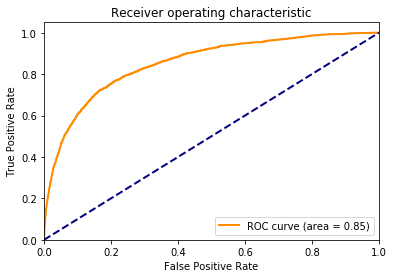

In [95]:
y_test_squeezed = y_test.reshape((len(test_index) * frames, CLASSES))
y_pred_squeezed = y_pred.reshape((len(test_index) * frames, CLASSES))
plot_ROC_curve(y_pred_squeezed[:, 1], y_test_squeezed[:, 1])

In [115]:
def add_noise(filename):
    y, sr = librosa.load(filename)
    noise = librosa.load('data/noise.wav')[0]
    index = random.randrange(0, noise.shape[0])
    noise *= ((y ** 2).mean() / (noise ** 2).mean()) / 4
    for i in range(y.shape[0]):
        y[i] += noise[index]
        index = (index + 1) % noise.shape[0]
    return y, sr

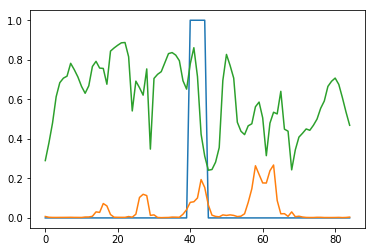

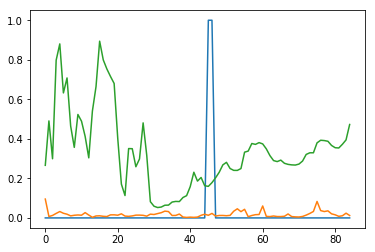

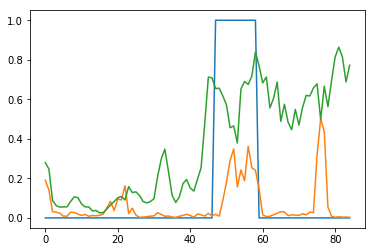

In [116]:
laughter_indices = []
for i in range(len(test_index)):
    if y_test[i, :, 1].sum() > 0:
        laughter_indices.append(i)
extractor = LibrosaExtractor()
predictor = RnnPredictor()
for i in range(3):
    index = random.choice(laughter_indices)
    plt.plot(np.arange(0, frames), y_test[index, :, 1])
    plt.plot(np.arange(0, frames), y_pred[index, :, 1])
    name = sorted(test_index)[index]
    path = 'data\\vocalizationcorpus\\data\\' + name + '.wav'
    y, sr = add_noise(path)
    librosa.output.write_wav('data\\noised.wav', y, sr)
    features = extractor.extract_features('data\\noised.wav')
    y_pred_noise = predictor.predict_proba(np.expand_dims(features, axis=0))[0]
    plt.plot(np.arange(0, frames), y_pred_noise[:, 1])
    plt.show()

As we see, adding noise to audio files without additional training strongly influences model accuracy.

In [117]:
model.save('models/model.h5')